# HiFiGAN Generator Types

In [1]:
import torch
import torch.nn
import numpy as np

import layers
import hifigan_generator
from importlib import reload
import wav_ema_dataset
from wav_ema_dataset import WavEMADataset
import collate as wav_ema_collate
reload(hifigan_generator)
reload(wav_ema_collate)
import scipy

import matplotlib.pyplot as plt

/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
ESPnet is not installed, cannot use espnet_hubert upstream
/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## HiFiCAR Generator: 1 second context to 5 EMA frames

In [2]:
context_len = 50 # 1 second in 50 Hz
out_len = 5
ar_len = 50
ar_ft_output = 128
ema_channels = 12
ar_input = ar_len * ema_channels
ar_hidden = 256

"""
ar_model:
    Input: (1, ema_channels, ar_len)
    Output: (1, ar_ft_output)
"""
ar_model = layers.PastFCEncoder(
    input_len=ar_input, 
    hidden_dim=ar_hidden, 
    output_dim=ar_ft_output
)

In [3]:
resblock_kernel_sizes=(3, 7)
resblock_dilations=[(1, 3, 5), (1, 3, 5)]
in_channels = 512 # WavLM CNN features
res_channels = 256
kernel_size = 3
bias = True
use_additional_convs = True
nonlinear_activation = "LeakyReLU"
nonlinear_activation_params={"negative_slope": 0.1}
blocks = torch.nn.ModuleList()

input_conv = torch.nn.Conv1d(
    in_channels + ar_ft_output,
    res_channels,
    kernel_size,
    1,
    padding=1
)

for j in range(len(resblock_kernel_sizes)):
    blocks += [
        layers.HiFiGANResidualBlock(
            kernel_size=resblock_kernel_sizes[j],
            channels=res_channels,
            dilations=resblock_dilations[j],
            bias=bias,
            use_additional_convs=use_additional_convs,
            nonlinear_activation=nonlinear_activation,
            nonlinear_activation_params=nonlinear_activation_params,
        )
    ]

output_conv = torch.nn.Sequential(
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=res_channels,
        out_channels=ema_channels,
        kernel_size=kernel_size,
        stride=1,
        padding=1
    ),
)

ema_conv = torch.nn.Sequential(
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=context_len,
        out_channels=out_len,
        kernel_size=kernel_size,
        stride=1,
        padding=1
    )
)

In [4]:
# Testing
audio_test = torch.zeros((1, 512, 50))

ar_test = torch.zeros((1, ema_channels, ar_len))
ar_feats = ar_model(ar_test)
ar_feats = ar_feats.unsqueeze(2).repeat(1, 1, audio_test.shape[2])


audio_test = torch.cat((audio_test, ar_feats), dim=1)
audio_test = input_conv(audio_test)


cs = 0.0
for block in blocks:
    cs += block(audio_test)

audio_test = cs / len(blocks)

print(f"audio_test: {audio_test.shape}")

audio_test = output_conv(audio_test)

audio_test = audio_test.permute(0, 2, 1)

print(f"audio_test: {audio_test.shape}")

ema = ema_conv(audio_test).permute(0, 2, 1)

print(f"ema output: {ema.shape}")

audio_test: torch.Size([1, 256, 50])
audio_test: torch.Size([1, 50, 12])
ema output: torch.Size([1, 12, 5])


## Fix Collating

In [5]:
audio_len = 368
in_audio = torch.zeros((1, 512, audio_len)) # WavLM CNN features
print(f"input audio: {in_audio.shape}")

def collate(in_audio, context_len, step_size):
    """
    Goal: 
        Input: (1, 512, audio_len)
        Output: (audio_len // step_size, 512, context_len)
    """

    truncated_audio = in_audio[:, :, :-(in_audio.shape[2] % context_len)]

    num_batches = in_audio.shape[2] // step_size
    collates = []
    for batch in range(num_batches):
        batch_start = batch * step_size
        if (batch_start + context_len) > truncated_audio.shape[2]:
            break
        collates.append(truncated_audio[:, :, batch_start:(batch_start + context_len)])
    collated = torch.cat(collates, dim=0)

    return collated

input audio: torch.Size([1, 512, 368])


In [6]:
audio_col = collate(in_audio, 50, 5)

In [7]:
audio_col.shape

torch.Size([61, 512, 50])

In [8]:
batch_ema = torch.zeros((1, 12, 368))
ema_col = collate(batch_ema, 50, 5)

In [9]:
ema_col[:, :, -5:].shape

torch.Size([61, 12, 5])

In [10]:
device = 0
gen = hifigan_generator.HiFiGANGenerator()
gen = gen.to(device)

In [11]:
torch.manual_seed(0)
gen(audio_col.to(device), ema_col.to(device)).shape

torch.Size([61, 12, 5])

In [12]:
dataset = WavEMADataset()

Loading files from directories...


/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [20]:
train_amt = int(len(dataset) * 0.9)
test_amt = len(dataset) - train_amt
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_amt, test_amt])
dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True,
    collate_fn=wav_ema_collate.car_collate)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=100, 
    shuffle=True,
    collate_fn=wav_ema_collate.car_collate)

In [21]:
batch = next(iter(dataloader))

In [22]:
print(batch[0].shape, batch[1].shape, batch[2].shape)

torch.Size([53, 512, 50]) torch.Size([53, 12, 50]) torch.Size([53, 12, 50])


In [24]:
audio = batch[0].squeeze(0)
ema = batch[1].squeeze(0)
print(ema.shape)

fmt_ema = ema.detach().cpu()
print(fmt_ema.shape)

clt_ema = wav_ema_collate.collate(ema, context_len=50)
print(clt_ema.shape)

unclt_ema = wav_ema_collate.uncollate(clt_ema).squeeze(0)
fmt_unclt_ema = unclt_ema.transpose(1, 0).detach().cpu()
print(fmt_unclt_ema.shape)

torch.Size([53, 12, 50])
torch.Size([53, 12, 50])
torch.Size([53, 12, 50])
torch.Size([2650, 12])


In [25]:
def correlations(pred_ema, true_ema):
    corrs = []
    for i in range(12):
        corr = np.corrcoef(pred_ema[i], true_ema[i])[0, 1]
        corrs.append(corr)
    return np.mean(corrs)

In [35]:
# Generator -> Correct EMA output autoregressively
@torch.no_grad()
def eval_gen(batch):
    # Collated features from batch
    clt_audio = batch[0].to(device)
    clt_ema = batch[1].to(device)

    # Add 10 "batches" of blank collated audio as zero padding to start so
    # the generator can autoregressively correctly generate the first 10 frames
    first_audio = torch.zeros((10, 512, 50)).to(device)
    clt_audio = torch.concatenate([first_audio, clt_audio], dim=0)

    # Initialize first EMA CAR to zeros
    first_ema = torch.zeros((1, 12, 50)).to(device)

    # Accumulate all the predicted EMA together and reuse as context
    context_ema = first_ema

    gen_ema = []

    for i in range(clt_audio.shape[0]):
        input_audio = clt_audio[i].unsqueeze(0)
        input_ema = context_ema[:, :, -50:]

        next_gen = gen(input_audio, input_ema)
        context_ema = torch.cat([context_ema, next_gen], dim=2)
    context_ema = context_ema[:, :, 50:]

    # Reformat for plotting purposes
    pred_ema = context_ema.squeeze(0).transpose(1, 0).detach().cpu()
    true_ema = wav_ema_collate.uncollate(clt_ema).squeeze(0).transpose(1, 0).detach().cpu()
    
    return pred_ema, true_ema

print(audio.shape)
audio = audio.to(device)
first_ema = torch.zeros((1, 12, 50)).to(device)
first_audio = torch.zeros((10, 512, 50)).to(device)
clt_audio = torch.concatenate([first_audio, audio], dim=0)

# clt_audio = wav_ema_collate.collate(audio, context_len=50)
clt_ema = clt_ema

print(clt_ema.shape)
print(clt_audio.shape)
print(first_ema.shape)

# First generation
gen_ema = gen(clt_audio[0].unsqueeze(0), first_ema)
context_ema = first_ema

gen_ema = []

for i in range(clt_audio.shape[0]):
    input_audio = clt_audio[i].unsqueeze(0)
    input_ema = context_ema[:, :, -50:]

    next_gen = gen(input_audio, input_ema)
    context_ema = torch.cat([context_ema, next_gen], dim=2)
context_ema = context_ema[:, :, 50:]
print(context_ema.shape)

pred_ema, true_ema = eval_gen(batch)
print(pred_ema.shape, true_ema.shape)
print(correlations(pred_ema, true_ema))

torch.Size([53, 512, 50])
torch.Size([53, 12, 50])
torch.Size([63, 512, 50])
torch.Size([1, 12, 50])
torch.Size([1, 12, 315])
torch.Size([315, 12]) torch.Size([2650, 12])
0.40850371924672885


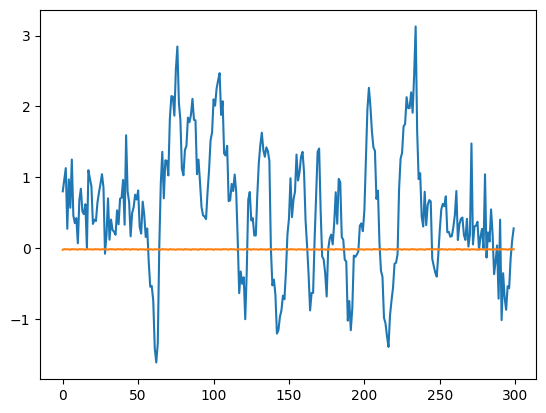

In [36]:
plt.plot(true_ema[:300, 0])
plt.plot(pred_ema[:300, 0])

In [32]:
window_size=50
def unroll_collated(features):
    return torch.concatenate(list(features), dim=1)

@torch.no_grad()
def eval_gen(batch):
    x = batch[0].to(device)
    y = batch[1].to(device)

    x = uncollate(x)
    x = wav_ema_collate.collate_features([x])
    y_unrolled = uncollate(y)

    ar = torch.zeros((1, 12, window_size)).to(device)
    pred = []
    for audio_feat in x:
        audio_feat = audio_feat.unsqueeze(0)
        pred.append(gen(audio_feat, ar)[:, :, :window_size])
        ar = torch.concatenate([ar, pred[-1]], dim=2)[:, :, 5:]
    full_pred = torch.concatenate(pred, dim=2).squeeze(0)
    full_pred = full_pred.transpose(1, 0).cpu().numpy()
    y_unrolled = y_unrolled.transpose(1, 0).cpu().numpy()
    corrs = []
    for i in range(12):
        length = min(len(full_pred), len(y_unrolled))
        corrs.append(scipy.stats.pearsonr(full_pred[:length, i], y_unrolled[:length, i])[0])
    corr_mean = np.mean(corrs)
    print("Correlations:", corr_mean)
    return full_pred, y_unrolled, corr_mean

def uncollate(collated, step_size=5):
    pieces = [collated[0]]
    for i in range(1, len(collated)):
        piece = collated[i]
        pieces.append(piece[:, -5:])
    return torch.concatenate(pieces, dim=1).unsqueeze(0)

In [37]:
device = 0
eval_batch = eval_gen(batch)

In [128]:
eval_batch[1].shape

(100, 12)

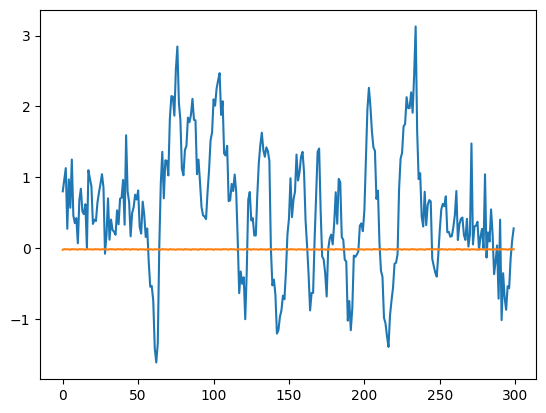

In [39]:
plt.plot(eval_batch[1][:300, 0])
plt.plot(eval_batch[0][:300, 0])

In [83]:
ema = torch.from_numpy(np.load("../../inversion/ema/china_pred.npy")).transpose(1, 0).unsqueeze(0)
ema = batch
ema_input = wav_ema_collate.collate(ema, 50)
print(ema_input.shape)

torch.Size([141, 12, 50])


In [236]:
# Collating audio and EMA features into rolled audio, EMA, and EMA_ar
seq_len = 638
input_audio = torch.zeros((1, 512, seq_len)).to(device)
input_ema = torch.zeros((1, 12, seq_len)).to(device)

# Add 5 frames of zero padding to the start of the EMA autoregressive input
# to offset it by 5, then remove the extra 5 unnecessary frames at the end.
input_ema_ar = torch.concatenate(
    [torch.zeros((1, 12, 5)).to(device), input_ema[:, :, :seq_len-5]], dim=2).to(device)

# first pass
first_audio = input_audio[:, :, :50]
print(first_audio.shape)

first_ema_ar = input_ema_ar[:, :, :50]
print(first_ema_ar.shape)

first_ema_y = input_ema[:, :, 45:50]
print(first_ema_y.shape)

audios = []
ema_ars = []
emas = []

truncated_seq_len = (seq_len - (seq_len % 5)) - 50
print(seq_len, truncated_seq_len)
for i in range(0, truncated_seq_len, 5):
    curr_audio = input_audio[:, :, i:i+50]
    audios.append(curr_audio)

    curr_ema_ar = input_ema_ar[:, :, i:i+50]
    ema_ars.append(curr_ema_ar)
    
    curr_ema = input_ema[:, :, i+45:i+50]
    emas.append(curr_ema)

audios = torch.cat(audios, dim=0)
ema_ars = torch.cat(ema_ars, dim=0)
emas = torch.cat(emas, dim=0)

print(audios.shape, ema_ars.shape, emas.shape)

def car_collate(batch):
    audio, ema = zip(*batch)

    audio = torch.cat(audio, dim=0)
    ema = torch.cat(ema, dim=0)

    audios = []
    ema_ars = []
    emas = []

    seq_len = audio.shape[2]

    truncated_seq_len = (seq_len - (seq_len % 5)) - 50
    for i in range(0, truncated_seq_len, 5):
        curr_audio = audio[:, :, i:i+50]
        audios.append(curr_audio)

        curr_ema_ar = ema[:, :, i:i+50]
        ema_ars.append(curr_ema_ar)
        
        curr_ema = ema[:, :, i+45:i+50]
        emas.append(curr_ema)

    audios = torch.cat(audios, dim=0)
    ema_ars = torch.cat(ema_ars, dim=0)
    emas = torch.cat(emas, dim=0)

    return audios, ema_ars, emas

torch.Size([1, 512, 50])
torch.Size([1, 12, 50])
torch.Size([1, 12, 5])
638 585
torch.Size([117, 512, 50]) torch.Size([117, 12, 50]) torch.Size([117, 12, 5])
